# Comparing Accuracy of BERT Using Pre and Post Tuning

## 1. Data Preperation

In [ ]:
# Uncomment out this line when testing this file
#pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.5 MB/s eta 0:00:00


In [ ]:
# Imports
import optuna
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
import re
import string


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### 1.1 Load and Preprocess Data

In [ ]:
# Load the dataset
df = pd.read_csv("HateSpeechDatasetBalanced.csv")

# Ensure the dataset has 'text' and 'label' columns
print(df.head())

# Preprocess text
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Lowercase
    text = text.lower()
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_text'] = df['Content'].apply(preprocess_text)

# Sample 25,000 observations from Label 0
df_label0 = df[df['Label'] == 0].sample(n=25000, random_state=42)

# Sample 25,000 observations from Label 1
df_label1 = df[df['Label'] == 1].sample(n=25000, random_state=42)

# Combine the sampled data into a balanced DataFrame
balanced_df = pd.concat([df_label0, df_label1]).reset_index(drop=True)

# Shuffle the balanced dataset to mix label 0 and label 1 samples
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

balanced_df.head()


                                             Content  Label
0  denial of normal the con be asked to comment o...      1
1  just by being able to tweet this insufferable ...      1
2  that is retarded you too cute to be single tha...      1
3  thought of a real badass mongol style declarat...      1
4                                afro american basho      1


,Content,Label,clean_text
0,my changes do not affect any of the concocted ...,1,my changes do not affect any of the concocted ...
1,rfc propose whatever rename the article with a...,0,rfc propose whatever rename the article with a...
2,i re wrote of your aids because you were askin...,0,i re wrote of your aids because you were askin...
3,googling is useless because of the absence of ...,0,googling is useless because of the absence of ...
4,martina garcia relic a mi hnas li ti key je en...,1,martina garcia relic a mi hnas li ti key je en...


### 1.2 Split the Data

In [ ]:
# Split into training and temp (which will be split into validation and test)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    balanced_df['clean_text'].tolist(), balanced_df['Label'].tolist(), test_size=0.3, random_state=42
)

# Split temp into validation and test sets
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)

print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")
print(f"Testing samples: {len(test_texts)}")


Training samples: 35000
Validation samples: 7500
Testing samples: 7500


## 2. Baseline Model Evaluation

### 2.1 Load the Pretrained Model

In [ ]:
# Load the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 2.2 Prepare the Data

In [ ]:
def tokenize(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='tf'
    )

# Tokenize the test texts
test_encodings = tokenize(test_texts)

# Create TensorFlow dataset for testing
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
)).batch(16)

# Tokenize the training and validation texts
train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).shuffle(1000).batch(16)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(16)


In [ ]:
def objective(trial):
    # Hyperparameters to tune
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32,64])
    freeze_layers = trial.suggest_int('freeze_layers', 3, 9, step=3)

    # Re-initialize the model to ensure we're starting fresh
    model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

    # Freeze the specified number of layers
    for layer in model.bert.encoder.layer[:freeze_layers]:
        layer.trainable = False

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.metrics.SparseCategoricalAccuracy('accuracy')
    model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

    # Prepare data with the current batch size
    train_dataset = tf.data.Dataset.from_tensor_slices((
        dict(train_encodings),
        train_labels
    )).shuffle(1000).batch(batch_size)

    val_dataset = tf.data.Dataset.from_tensor_slices((
        dict(val_encodings),
        val_labels
    )).batch(batch_size)

    # Train the model
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=3,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)
        ],
        verbose=0  # Set verbose to 0 to reduce output during tuning
    )

    # Get the best validation accuracy of this trial
    val_accuracy = max(history.history['val_accuracy'])

    # Report the validation accuracy to Optuna
    return val_accuracy


### 2.3 Running Optuna Study

In [ ]:
# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective, n_trials=10)

[I 2024-10-01 15:29:36,353] A new study created in memory with name: no-name-c77fdf93-c2d7-460e-beb1-e8586925ef48
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2024-10-01 15:57:25,899] Trial 0 finished with value: 0.8481333255767822 and parameters: {'learning_rate': 3.5724301244604476e-05, 'batch_size': 32, 'freeze_layers': 6}. Best is trial 0 with value: 0.8481333255767822.
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
Yo

### 2.4 Return best Hyperparameters and Examine Them

In [ ]:
print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial

print(f"  Value: {trial.value}")

print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Number of finished trials: 10
Best trial:
  Value: 0.8573333621025085
  Params: 
    learning_rate: 3.812957299804759e-05
    batch_size: 64
    freeze_layers: 6


In [ ]:
import optuna.visualization as vis

vis.plot_optimization_history(study).show()
vis.plot_param_importances(study).show()

## 3. Training the Final Model with Best Hyperparameters

In [ ]:
# Extract the best hyperparameters
best_learning_rate = trial.params['learning_rate']
best_batch_size = trial.params['batch_size']
best_freeze_layers = trial.params['freeze_layers']

print("\nTraining the final model with best hyperparameters...")

# Re-initialize the model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Freeze the specified number of layers
for layer in model.bert.encoder.layer[:best_freeze_layers]:
    layer.trainable = False

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=best_learning_rate)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Prepare data with the best batch size
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).shuffle(1000).batch(best_batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(best_batch_size)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)
    ],
    verbose=1
)


Training the final model with best hyperparameters...


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
547/547 [==============================] - 805s 1s/step - loss: 0.4071 - accuracy: 0.8131 - val_loss: 0.3495 - val_accuracy: 0.8417
Epoch 2/3
547/547 [==============================] - 775s 1s/step - loss: 0.2775 - accuracy: 0.8818 - val_loss: 0.3549 - val_accuracy: 0.8539


## 5. Evaluation and Visualization

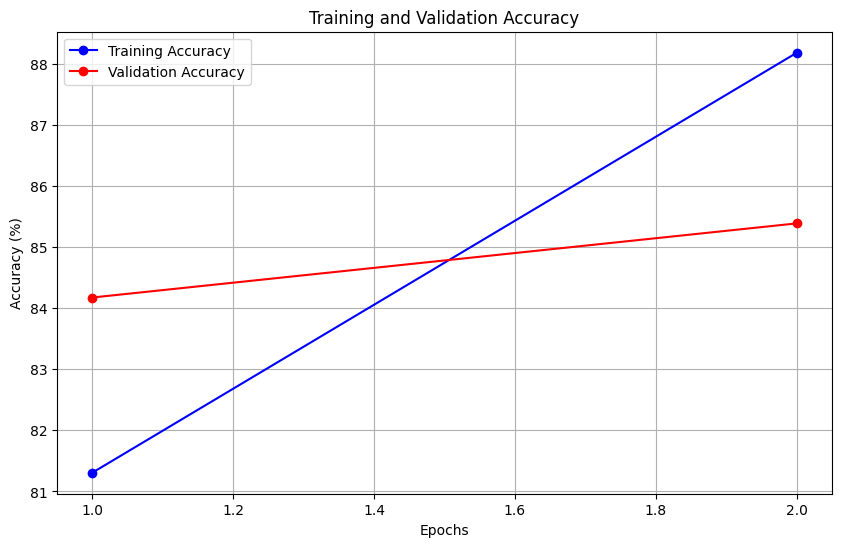

In [ ]:
# Extract accuracy values
train_acc = [acc * 100 for acc in history.history['accuracy']]
val_acc = [acc * 100 for acc in history.history['val_accuracy']]

# Epochs
epochs = range(1, len(train_acc) + 1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, 'b-o', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-o', label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

118/118 [==============================] - 62s 521ms/step - loss: 0.3421 - accuracy: 0.8456
Test Accuracy: 84.56%
118/118 [==============================] - 64s 520ms/step

Classification Report:
                 precision    recall  f1-score   support

Not Hate Speech       0.83      0.88      0.85      3813
    Hate Speech       0.87      0.81      0.84      3687

       accuracy                           0.85      7500
      macro avg       0.85      0.85      0.85      7500
   weighted avg       0.85      0.85      0.85      7500



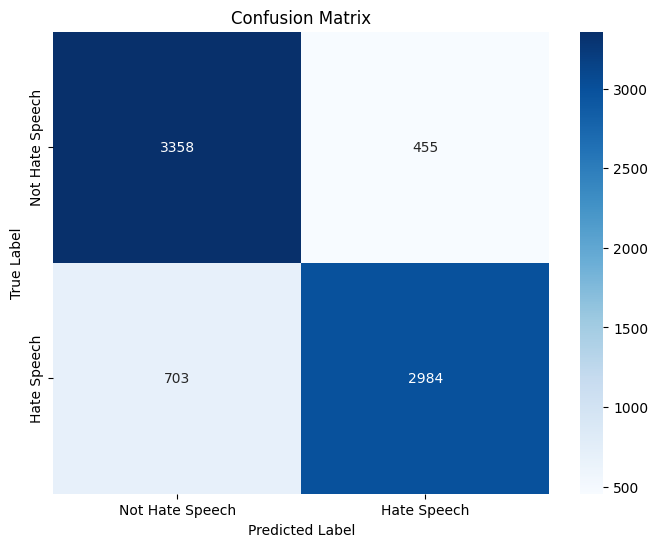

In [ ]:
# Prepare the test dataset with the best batch size
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
)).batch(best_batch_size)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Make predictions
predictions = model.predict(test_dataset)
pred_logits = predictions.logits
pred_labels = np.argmax(pred_logits, axis=1)

# True labels
true_labels = np.array(test_labels)

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Classification report
report = classification_report(true_labels, pred_labels, target_names=['Not Hate Speech', 'Hate Speech'])
print("\nClassification Report:")
print(report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Hate Speech', 'Hate Speech'],
            yticklabels=['Not Hate Speech', 'Hate Speech'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
missclassified_indicies = np.where(pred_labels != true_labels)[0]

# Decode test texts
def decode_text(encoded_text):
    return tokenizer.decode(encoded_text, skip_special_tokens=True)

# Assuming 'test_encodings' contains the token IDs
# Extract the input_ids from test_encodings
test_text_ids = test_encodings['input_ids']

decoded_test_texts = [decode_text(text_ids) for text_ids in test_text_ids] # Decode token IDs to text

# Extract false positives and false negatives
false_positives = []
false_negatives = []

# Mapping of label indices to label names
label_map = {0: 'Not Hate Speech', 1: 'Hate Speech'}

for idx in missclassified_indicies:
    if true_labels[idx] == 0:  # Not Hate Speech
        false_positives.append((decoded_test_texts[idx], label_map[pred_labels[idx]], label_map[true_labels[idx]]))
    else:  # Hate Speech
        false_negatives.append((decoded_test_texts[idx], label_map[pred_labels[idx]],
                                label_map[true_labels[idx]]))

# Display a few examples of false positives
print("\nExamples of False Positives:")
for text, pred_label, true_label in false_positives[:5]:
    print(f"Text: {text}")
    print(f"Predicted Label: {pred_label}")
    print(f"True Label: {true_label}")

# Display a few examles of false negatives
print("\nExamples of False Negatives:")
for text, pred_label, true_label in false_negatives[:5]:
    print(f"Text: {text}")
    print(f"Predicted Label: {pred_label}")
    print(f"True Label: {true_label}")


Examples of False Positives:
Text: no one gets preferential treatment at the best universities all their policies state that everyone is equal everywhere and any further disagreements like the jewish men are being propped up by society at the detriment of the white man is ridiculous
Predicted Label: Hate Speech
True Label: Not Hate Speech
Text: roland ti is tame
Predicted Label: Hate Speech
True Label: Not Hate Speech
Text: wikiproject lgbt studies class stub person project biography
Predicted Label: Hate Speech
True Label: Not Hate Speech
Text: golly gompers and dad gum son you lying cheating scoundrels fucking did it man up and own it ya chicken shit pussy republican
Predicted Label: Hate Speech
True Label: Not Hate Speech
Text: the meps bear that travelled to sandy hook in with hope that another gun massacre would never occur again
Predicted Label: Hate Speech
True Label: Not Hate Speech

Examples of False Negatives:
Text: retweet bitches be fallen so in a w niggass says she might 

In [ ]:
# Save the model and tokenizer
model.save_pretrained("finetuned_bert_hatespeech")
tokenizer.save_pretrained("finetuned_bert_hatespeech")

('finetuned_bert_hatespeech/tokenizer_config.json',
 'finetuned_bert_hatespeech/special_tokens_map.json',
 'finetuned_bert_hatespeech/vocab.txt',
 'finetuned_bert_hatespeech/added_tokens.json')

In [ ]:
# Load the model and tokenizer
loaded_model = TFBertForSequenceClassification.from_pretrained("finetuned_bert_hatespeech")
loaded_tokenizer = BertTokenizer.from_pretrained("finetuned_bert_hatespeech")

Some layers from the model checkpoint at finetuned_bert_hatespeech were not used when initializing TFBertForSequenceClassification: ['dropout_455']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at finetuned_bert_hatespeech.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [ ]:
import numpy as np
import re
import string

# Example of an inferenece pipeline

def predict_hate_speech(text, loaded_model, loaded_tokenizer):
    """Predicts if a given text contains hate speech using a fine-tuned BERT model.

    Args:
        text (str): The input text to analyze.
        loaded_model: The loaded fine-tuned BERT model.
        loaded_tokenizer: The loaded tokenizer associated with the model.

    Returns:
        int: The predicted label (0 for "Not Hate Speech", 1 for "Hate Speech").
    """
    def preprocess_text(text):
        # Remove URLs
        text = re.sub(r'http\S+', '', text)
        # Remove mentions and hashtags
        text = re.sub(r'@\w+|#\w+', '', text)
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Lowercase
        text = text.lower()
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    preprocessed_text = preprocess_text(text)
    inputs = loaded_tokenizer(preprocessed_text, return_tensors="tf")
    predictions = loaded_model(**inputs)
    predicted_label = np.argmax(predictions.logits, axis=1)[0]  # Extract the single predicted label
    return predicted_label

In [ ]:
# Example of test messages
test_texts = [
    "I absolutely love this new phone! It's so sleek and fast.", # Expected: Not Hate Speech
    "All immigrants are criminals and should be deported.",  # Expected: Hate Speech
    "This movie was a complete waste of time and money.", # Expected: Not Hate Speech
    "I hate people of that race, they're all disgusting.", # Expected: Hate Speech
]
label = ["Not Hate Speech","Hate Speech","Not Hate Speech","Hate Speech"]

for i in range(len(test_texts)):
    prediction = predict_hate_speech(test_texts[i], loaded_model, loaded_tokenizer)
    if prediction == 0:
        print(f"'{test_texts[i]}' \nPredicted: Not Hate Speech")
    else:
        print(f"'{test_texts[i]}' \nPredicted: Hate Speech")
    print(f"Expected: {label[i]}\n")

'I absolutely love this new phone! It's so sleek and fast.' 
Predicted: Not Hate Speech
Expected: Not Hate Speech

'All immigrants are criminals and should be deported.' 
Predicted: Hate Speech
Expected: Hate Speech

'This movie was a complete waste of time and money.' 
Predicted: Not Hate Speech
Expected: Not Hate Speech

'I hate people of that race, they're all disgusting.' 
Predicted: Hate Speech
Expected: Hate Speech

